In [52]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon, ttest_rel

NUM_PCS = 30
PATHS = {
    "ElasticNet": {
        "base": f"01_simple_baselines/results/elastic_net/voom_{NUM_PCS}_pcs.csv",
        "feat": f"01_simple_baselines/results/elastic_net/voom_{NUM_PCS}_pcs_tissue_growth.csv",
    },
    "RandomForest": {
        "base": f"02_complex_baselines/results/rf/voom_{NUM_PCS}_pcs.csv",
        "feat": f"02_complex_baselines/results/rf/voom_{NUM_PCS}_pcs_tissue_growth.csv",
    },
}

def load_set(path, model, set_tag):
    df = pd.read_csv(path)
    df["Model"] = model
    df["Set"] = set_tag  # base / feat
    # normalize columns
    df.rename(columns=lambda c: c.strip().replace("²", "^2"), inplace=True)
    if "r2_mean" not in df.columns and "r2_global" in df.columns:
        df = df.rename(columns={"r2_global": "r2_mean", "rmse": "rmse_mean"})
    # keep a tidy subset
    keep = ["DRUG_ID", "n_samples", "r2_mean", "rmse_mean", "Model", "Set"]
    missing = [c for c in keep if c not in df.columns]
    if missing:
        raise ValueError(f"Missing expected columns in {path}: {missing}")
    return df[keep]

frames = []
for model, paths in PATHS.items():
    for set_tag, path in paths.items():
        frames.append(load_set(path, model, set_tag))

feat_df = pd.concat(frames, ignore_index=True)
print("✅ combined:", feat_df.shape)
feat_df.head()


✅ combined: (2788, 6)


,DRUG_ID,n_samples,r2_mean,rmse_mean,Model,Set
0,1,391,0.031359,1.069695,ElasticNet,base
1,3,356,0.033849,1.958721,ElasticNet,base
2,5,394,0.137313,1.501935,ElasticNet,base
3,6,403,-0.003588,0.884127,ElasticNet,base
4,9,396,0.073031,1.406065,ElasticNet,base


In [53]:
# %%
pretty_map = {"ElasticNet": "Elastic Net", "RandomForest": "Random Forest"}
set_map = {"base": f"Baseline ({NUM_PCS} PCs)", "feat": "+ Tissue & Growth"}

df_plot = feat_df.copy()
df_plot["ModelPretty"] = df_plot["Model"].map(pretty_map)
df_plot["SetPretty"] = df_plot["Set"].map(set_map)


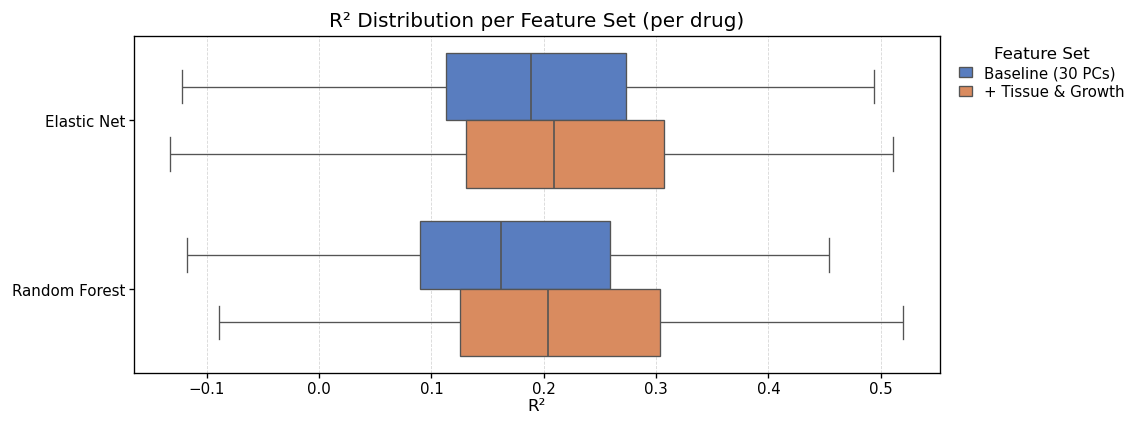

/tmp/ipykernel_2203172/1774827040.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([short_map.get(t.get_text(), t.get_text()) for t in ax.get_yticklabels()])


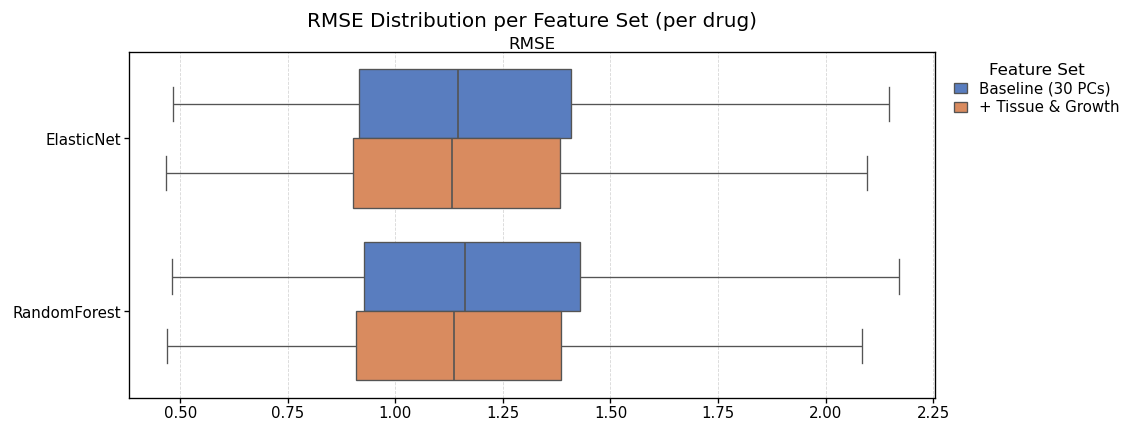

In [61]:
# --- R² ---
fig, ax = plt.subplots(figsize=(8, 3.6))  # a bit shorter vertically
sns.boxplot(
    data=df_plot, x="r2_mean", y="ModelPretty",
    hue="SetPretty", palette="muted",
    showfliers=False, dodge=True, ax=ax,
    boxprops=dict(linewidth=0.8),
    whiskerprops=dict(linewidth=0.8),
    capprops=dict(linewidth=0.8),
    medianprops=dict(linewidth=1.0),   # keep median slightly clearer
)

# labels/title
ax.set_title("R² Distribution per Feature Set (per drug)", fontsize=12)
ax.set_xlabel("R²", fontsize=10, labelpad=1)  # smaller + closer
plt.subplots_adjust(bottom=0.07)              # shrink bottom margin a bit more
ax.set_ylabel("")

# slimmer legend (Option A)
leg = ax.legend(
    title="Feature Set", frameon=False, loc="upper left",
    bbox_to_anchor=(1.01, 1.0), fontsize=9, title_fontsize=10,
    handlelength=0.9, borderpad=0.2, labelspacing=0.25
)

# thin spines + ticks
for sp in ax.spines.values():
    sp.set_linewidth(0.8)
ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)

# lighter grid
ax.grid(axis="x", linestyle="--", alpha=0.5, linewidth=0.5)

# tighten the bottom margin
plt.subplots_adjust(left=0.14, right=0.98, top=0.90, bottom=0.12)

plt.show()



# %% RMSE
fig, ax = plt.subplots(figsize=(8, 3.6))
sns.boxplot(
    data=df_plot, x="rmse_mean", y="ModelPretty",
    hue="SetPretty", palette="muted",
    showfliers=False, dodge=True, ax=ax,
    boxprops=dict(linewidth=0.8),
    whiskerprops=dict(linewidth=0.8),
    capprops=dict(linewidth=0.8),
    medianprops=dict(linewidth=1.0),
)

# (optional) shorten y labels if you haven't already
short_map = {"Elastic Net": "ElasticNet", "Random Forest": "RandomForest"}
ax.set_yticklabels([short_map.get(t.get_text(), t.get_text()) for t in ax.get_yticklabels()])
ax.tick_params(axis="y", labelsize=10, pad=3)

# title + label on TOP (set to 'bottom' and tweak bottom= if you prefer)
ax.set_title("RMSE Distribution per Feature Set (per drug)", fontsize=12)
ax.xaxis.set_label_position('top')  # <- change to 'bottom' to keep it below
ax.set_xlabel("RMSE", fontsize=10, labelpad=2)
ax.set_ylabel("")

# slim legend
ax.legend(
    title="Feature Set", frameon=False, loc="upper left",
    bbox_to_anchor=(1.01, 1.0), fontsize=9, title_fontsize=10,
    handlelength=0.9, borderpad=0.2, labelspacing=0.25
)

# thin spines/ticks + lighter grid
for sp in ax.spines.values():
    sp.set_linewidth(0.8)
ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)
ax.grid(axis="x", linestyle="--", alpha=0.5, linewidth=0.5)

# tight layout (shrink bottom; adjust to taste)
plt.subplots_adjust(left=0.14, right=0.98, top=0.88, bottom=0.08)
plt.show()


In [55]:
# %% paired tests: feat vs base within each model (per DRUG_ID)
def paired_set_tests(df_model, metric="r2_mean"):
    wide = df_model.pivot_table(index="DRUG_ID", columns="Set", values=metric, aggfunc="mean").dropna()
    if wide.empty:
        return None
    # positive delta means FEAT is better
    if metric == "r2_mean":
        d = wide["feat"] - wide["base"]
    else:  # rmse: lower is better
        d = wide["base"] - wide["feat"]
    n = len(d)
    return {
        "n": n,
        "delta_mean": d.mean(),
        "delta_median": d.median(),
        "win_rate": (d > 0).mean(),  # fraction of drugs where FEAT wins
        "wilcoxon_p": wilcoxon(d, zero_method="pratt").pvalue if n >= 5 else np.nan,
        "ttest_p": ttest_rel(wide["feat"], wide["base"], nan_policy="omit").pvalue if n >= 5 else np.nan
    }

rows = []
for model in ["ElasticNet", "RandomForest"]:
    df_m = feat_df[feat_df["Model"] == model]
    out_r2 = paired_set_tests(df_m, "r2_mean")
    out_rmse = paired_set_tests(df_m, "rmse_mean")
    if out_r2: rows.append({"Model": model, "Metric": "R² (FEAT - BASE)", **out_r2})
    if out_rmse: rows.append({"Model": model, "Metric": "RMSE (BASE - FEAT)", **out_rmse})

set_summary = pd.DataFrame(rows)
display(set_summary)


,Model,Metric,n,delta_mean,delta_median,win_rate,wilcoxon_p,ttest_p
0,ElasticNet,R² (FEAT - BASE),697,0.022555,0.013129,0.730273,1.982085e-46,1.733019e-45
1,ElasticNet,RMSE (BASE - FEAT),697,0.020778,0.009587,0.733142,1.019561e-53,1.304721e-50
2,RandomForest,R² (FEAT - BASE),697,0.040330,0.034256,0.862267,1.339151e-88,3.301586e-95
3,RandomForest,RMSE (BASE - FEAT),697,0.033516,0.022324,0.878049,5.802210e-92,5.532315e-79


In [56]:
# %% aggregate stats per feature set
def agg_stats(df, metric):
    g = (
        df.groupby(["ModelPretty", "SetPretty"], as_index=False)[metric]
          .agg(mean="mean", std="std", n="count")
    )
    g["se"] = g["std"] / np.sqrt(g["n"])
    g["ci95"] = 1.96 * g["se"]
    g["metric"] = metric
    return g

stats_r2 = agg_stats(df_plot, "r2_mean")
stats_rmse = agg_stats(df_plot, "rmse_mean")

summary_table = pd.concat([stats_r2, stats_rmse], ignore_index=True)
summary_table = summary_table.rename(columns={"mean": "Mean", "std": "Std", "n": "N", "ci95": "95% CI"})

display(summary_table[["metric", "ModelPretty", "SetPretty", "N", "Mean", "Std", "95% CI"]].round(4))


,metric,ModelPretty,SetPretty,N,Mean,Std,95% CI
0,r2_mean,Elastic Net,+ Tissue & Growth,697,0.2179,0.1155,0.0086
1,r2_mean,Elastic Net,Baseline (30 PCs),697,0.1953,0.1046,0.0078
2,r2_mean,Random Forest,+ Tissue & Growth,697,0.2137,0.1206,0.0090
3,r2_mean,Random Forest,Baseline (30 PCs),697,0.1733,0.1094,0.0081
4,rmse_mean,Elastic Net,+ Tissue & Growth,697,1.1693,0.3506,0.0260
5,rmse_mean,Elastic Net,Baseline (30 PCs),697,1.1901,0.3607,0.0268
6,rmse_mean,Random Forest,+ Tissue & Growth,697,1.1712,0.3488,0.0259
7,rmse_mean,Random Forest,Baseline (30 PCs),697,1.2047,0.3626,0.0269
